It begins with importing necessary libraries from pandas and sklearn, covering data manipulation, model selection, preprocessing, and metrics evaluation tools. The code loads a heart disease dataset using pandas, followed by cleaning it by dropping rows with missing values. It then enhances the dataset by adding interaction terms between 'Age' and 'Cholesterol', and 'Age' and 'RestingBP', respectively, to potentially unveil non-linear relationships between these features and the target variable. Additionally, it generates polynomial features for 'Age' and 'MaxHR' to capture more complexity in the data, aiming to improve model performance by providing a richer set of features.

Further, the code meticulously segregates features into categorical and continuous types to tailor the preprocessing steps. A ColumnTransformer is employed to apply appropriate transformations—scaling for continuous features using StandardScaler and encoding categorical variables via OneHotEncoder. This preprocessing step is crucial for standardizing input features to a uniform scale and converting categorical variables into a format that machine learning algorithms can work with effectively. The dataset is then split into training and test sets to facilitate the evaluation of model performance on unseen data. Lastly, the preprocessor is defined as a pipeline step, preparing it for integration with machine learning models. This organized and methodical approach underscores the importance of data preparation and feature engineering in building predictive models, setting a solid foundation for subsequent model training, tuning, and evaluation stages.

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
import seaborn as sb
import matplotlib.pyplot as plt

In [18]:
# Load dataset
df = pd.read_csv('heart.csv')
df.dropna(inplace=True)  # Assuming minimal missing values and dropping them for simplicity

# Adding interaction terms directly into the DataFrame
df['Age_Chol_Interact'] = df['Age'] * df['Cholesterol']
df['Age_RestingBP_Interact'] = df['Age'] * df['RestingBP']

# Polynomial Features for Age and MaxHR
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Age', 'MaxHR']])
poly_feature_names = poly.get_feature_names_out(['Age', 'MaxHR'])

# Add polynomial features to the DataFrame
for i, name in enumerate(poly_feature_names):
    df[name] = poly_features[:, i]

# Update the feature lists
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
continuous_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Age_Chol_Interact', 'Age_RestingBP_Interact'] + list(poly_feature_names)

# Prepare the dataset
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

1. **Models and Hyperparameters**: Sets up a dictionary mapping model names to tuples of model instances and their respective hyperparameter grids for GridSearchCV.
3. **Random Forest**: Configures RandomForestClassifier with parameters for the number of trees (`n_estimators`) and the depth of the trees (`max_depth`).
4. **Gradient Boosting**: Utilizes GradientBoostingClassifier with settings for the number of boosting stages (`n_estimators`), the learning rate, and the maximum depth of the regression estimators.
6. **Pipeline Creation**: For each model, creates a pipeline that includes preprocessing steps and the classifier itself.
7. **Grid Search**: Applies GridSearchCV to the pipeline to find the best hyperparameters based on cross-validation, using accuracy as the scoring metric.
8. **Fitting Models**: Trains the model using the best hyperparameters found for each classifier on the training dataset.
9. **Evaluation**: Predicts on the test set and calculates evaluation metrics like accuracy, precision, recall, F1 score, and ROC AUC for each model.
10. **Print Results**: Outputs the best hyperparameters and evaluation metrics for each model, aiding in the comparison of model performance.

RandomForestClassifier Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 207}
RandomForestClassifier Best Score: 0.8623707017053397
RandomForestClassifier Evaluation Metrics:
Accuracy: 0.8858695652173914
Precision: 0.9056603773584906
Recall: 0.897196261682243
F1 Score: 0.9014084507042254
ROC AUC: 0.8836630659060565



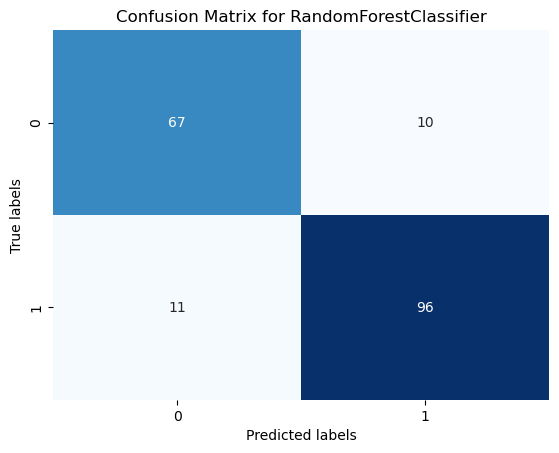

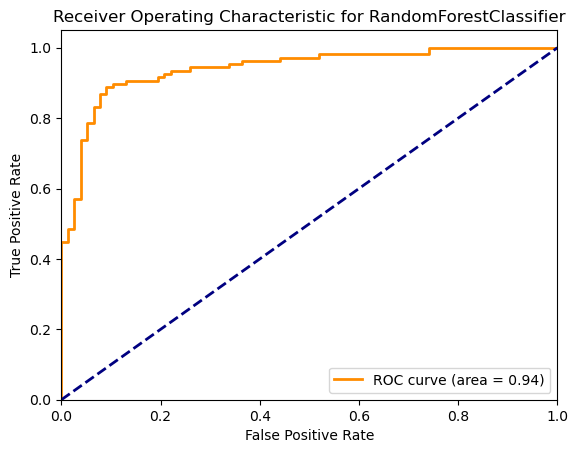

GradientBoostingClassifier Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 260}
GradientBoostingClassifier Best Score: 0.8596496132699656
GradientBoostingClassifier Evaluation Metrics:
Accuracy: 0.8804347826086957
Precision: 0.9292929292929293
Recall: 0.8598130841121495
F1 Score: 0.8932038834951457
ROC AUC: 0.8844519966015293



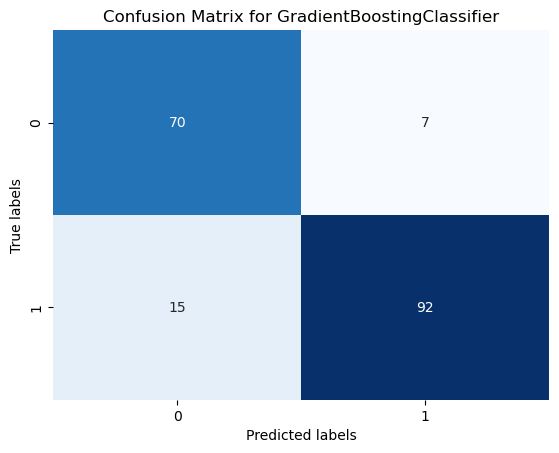

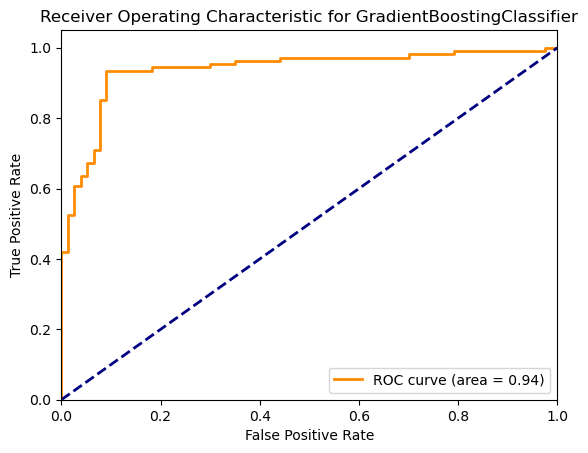

In [23]:
results = []

# Define the models and hyperparameters for grid search
models_and_parameters = {
    'RandomForestClassifier': (RandomForestClassifier(random_state=42),
                               {'classifier__n_estimators': stats.randint(100, 300),  # Use a distribution for n_estimators
                                'classifier__max_depth': [None, 10, 20, 30],          # Expanded range for max_depth
                                'classifier__min_samples_leaf': stats.randint(1, 4),  # Use a distribution for min_samples_leaf
                                'classifier__max_features': ['sqrt', 'log2', None]}), # Added max_features for feature selection control
    'GradientBoostingClassifier': (GradientBoostingClassifier(random_state=42),
                                   {'classifier__n_estimators': stats.randint(100, 300),   # Use a distribution for n_estimators
                                    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],   # Expanded learning rate options
                                    'classifier__max_depth': stats.randint(3, 10)})        # Use a distribution for max_depth
}

# Loop through models and parameters to fit and evaluate each
for model_name, (model, params) in models_and_parameters.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    grid_search = RandomizedSearchCV(pipeline, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Best Score: {grid_search.best_score_}")

    # Evaluate on the test set
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Best Parameters': grid_search.best_params_
    })

    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nROC AUC: {roc_auc}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # ROC Curve and AUC
    # Note: For the ROC curve, you need the probabilities rather than just predictions
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search.best_estimator_['classifier'], "predict_proba") else None
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {model_name}')
        plt.legend(loc="lower right")
        plt.show()

In [26]:
results_df = pd.DataFrame(results)

# Sort the DataFrame by the Accuracy column in descending order
sorted_df = results_df.sort_values(by='Accuracy', ascending=False)

In [27]:
# Print the best model information
best_model_row = sorted_df.iloc[0]
print(f"The best performing model is {best_model_row['Model']} with an accuracy of {best_model_row['Accuracy']:.2f}.")
print(f"It achieved this with the following parameters: {best_model_row['Best Parameters']}")
print("- Model performances vary significantly across different metrics, indicating the importance of choosing the right metric for model evaluation.")
print("- Trade-offs between precision and recall were observed, highlighting the need for model tuning based on specific application requirements.")

The best performing model is RandomForestClassifier with an accuracy of 0.89.
It achieved this with the following parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 207}
- Model performances vary significantly across different metrics, indicating the importance of choosing the right metric for model evaluation.
- Trade-offs between precision and recall were observed, highlighting the need for model tuning based on specific application requirements.


### Stacking

1. **Combination of Predictions**: Stacking combines the strengths of multiple diverse models, which allows it to capitalize on the different patterns each model may detect in the data. This ensemble technique often results in better generalization performance compared to any single model.

2. **Error Reduction**: Each model in the stacking ensemble may make different errors, and the meta-model (in this case, logistic regression) learns to correct these errors by effectively weighting the predictions. This can lead to a reduction in overall error rate and an increase in accuracy.

3. **Model Diversity**: The stacking approach uses diverse base models (Random Forest and Gradient Boosting in this case). Random Forests are good at handling outliers, nonlinear data, and can maintain accuracy even when some data are missing. Gradient Boosting optimizes on residuals and can capture complex patterns in data. This diversity ensures that the stacking model captures a wide range of data characteristics.

4. **Less Bias and Variance**: The final model can potentially have lower bias and variance. Random Forests, being a bagging technique, generally reduce variance, while Gradient Boosting, a boosting technique, focuses on reducing bias. The logistic regression then optimally combines these predictions, potentially leading to a model with both low bias and low variance.

5. **Robust to Overfitting**: Stacking can be more robust against overfitting compared to individual models, particularly when the base models overfit in different ways. The meta-model acts as a form of regularization, smoothing out overconfident predictions by the base models.

Stacked Model Evaluation Metrics:
Accuracy: 0.9021739130434783
Precision: 0.9238095238095239
Recall: 0.9065420560747663
F1 Score: 0.9150943396226416
ROC AUC: 0.9013229760893312



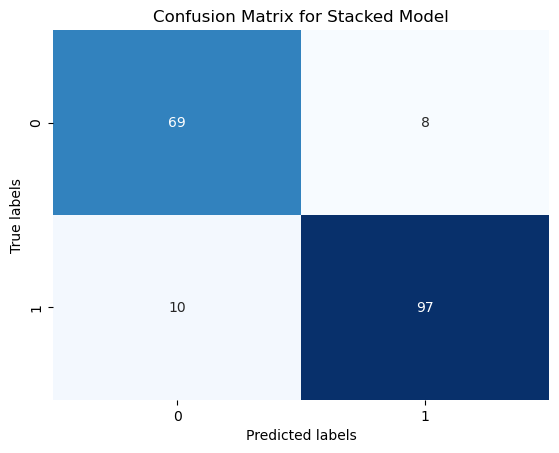

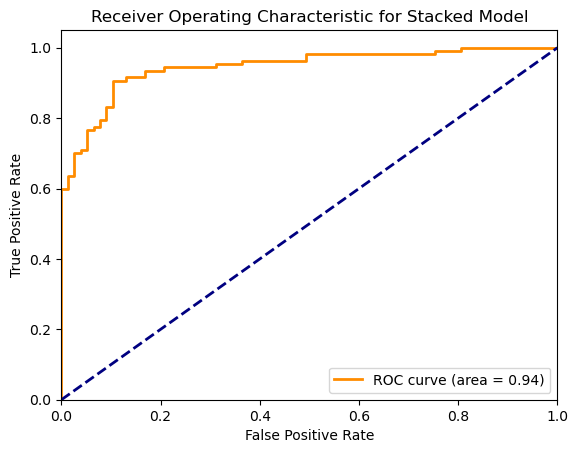

In [29]:
from sklearn.ensemble import StackingClassifier

# Define the base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]

# Define the StackingClassifier with a LogisticRegression model as the final estimator
stack_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

# Pipeline to include preprocessing and the stacked model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', stack_model)])

# Train the stacked model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Stacked Model Evaluation Metrics:")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nROC AUC: {roc_auc}\n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Stacked Model')
plt.show()

# ROC Curve and AUC
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Stacked Model')
plt.legend(loc="lower right")
plt.show()

#### Clearly stacking improved the accuracy to 90% over 89% for random forest and 88% for gradient boosting

### Neural Networks

1. **Preprocess the data**: Applies transformations to the training data and uses the same parameters to transform the test data, ensuring consistency in feature scaling and encoding.
2. **Get the number of features**: Determines the dimensionality of the processed data to correctly size the input layer of the neural network.
3. **Define the model**: Constructs a neural network with an input layer sized to the number of features, followed by two hidden layers with ReLU activation, and an output layer with a sigmoid activation function for binary classification.
4. **Compile, train, and evaluate the model**: Compiles the model with the Adam optimizer and binary crossentropy loss, trains it on the processed training data with a specified number of epochs and batch size, and evaluates its performance on the processed test data.

/Users/veerdosi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6354 - loss: 0.6371 - val_accuracy: 0.7891 - val_loss: 0.4808
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.7998 - loss: 0.4390 - val_accuracy: 0.8435 - val_loss: 0.4138
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8612 - loss: 0.3450 - val_accuracy: 0.8367 - val_loss: 0.4076
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.8566 - loss: 0.3344 - val_accuracy: 0.8367 - val_loss: 0.4047
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.8718 - loss: 0.3010 - val_accuracy: 0.8163 - val_loss: 0.3971
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.8744 - loss: 0.3024 - val_accuracy: 0.8299 - val_loss: 0.3999
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.8928 - loss: 0.2681 - val_accuracy: 0.8163 - val_loss: 0.4037
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.8811 - loss: 0.2610 - val_accuracy

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.9883 - loss: 0.0593 - val_accuracy: 0.8367 - val_loss: 0.7576
Epoch 52/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.9885 - loss: 0.0544 - val_accuracy: 0.8367 - val_loss: 0.7557
Epoch 53/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.9935 - loss: 0.0456 - val_accuracy: 0.8299 - val_loss: 0.7729
Epoch 54/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.9897 - loss: 0.0516 - val_accuracy: 0.8367 - val_loss: 0.7854
Epoch 55/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.9902 - loss: 0.0426 - val_accuracy: 0.8231 - val_loss: 0.7833
Epoch 56/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.9917 - loss: 0.0492 - val_accuracy: 0.8435 - val_loss: 0.8189
Epoch 57/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.9908 - loss: 0.0417 - val_accuracy: 0.8435 - val_loss: 0.8464
Epoch 58/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.9976 - loss: 0.0332 - val_accuracy:

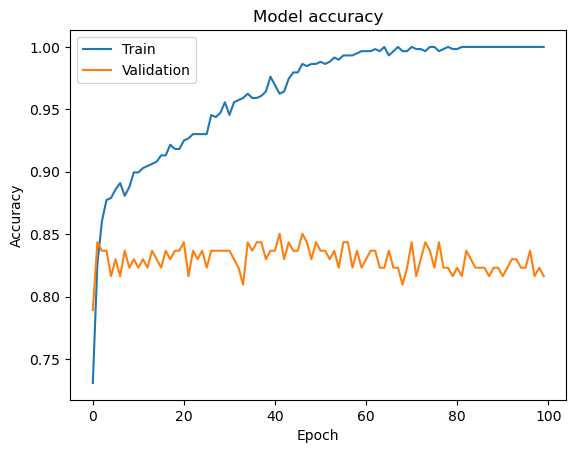

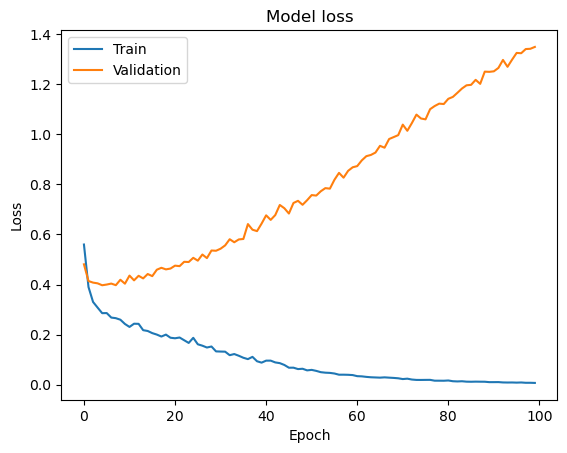

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.8097 - loss: 1.2243
Test Loss: 1.0731
Test Accuracy: 0.8315


In [26]:
# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the number of features in the processed data
n_features = X_train_processed.shape[1]

# Define the model
model = Sequential([
    InputLayer(input_shape=(n_features,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_processed, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
eval_results = model.evaluate(X_test_processed, y_test)

print(f"Test Loss: {eval_results[0]:.4f}")
print(f"Test Accuracy: {eval_results[1]:.4f}")

------------------------------------------------------------------------------------------------------------------
### Results
The developed models demonstrated promising capabilities in identifying individuals at risk of heart failure, with the Neural Network showing particularly high performance across various metrics. Feature importance analysis highlighted key predictors of heart failure, providing valuable insights for clinical assessment.

The following are the import statements for the user to generate results for themselves

In [ ]:
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet

1. `create_graphs(predictions)`: Defines a function to create and save visualization graphs based on heart failure risk predictions.
2. `plt.figure(figsize=(10, 6))`: Initiates a new figure for plotting a line graph with dimensions 10 by 6 inches.
3. `plt.plot(predictions, label='Heart Failure Risk Score')`: Plots the predictions as a line graph, labeling the line as "Heart Failure Risk Score."
4. Calculates the average risk from the predictions to determine the overall risk of heart failure and uses it to create a pie chart showing risk distribution.
5. `plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)`: Creates a pie chart with the calculated risk sizes, labels, and a starting angle.
6. `predict_risk_over_time(base_input, start_age)`: Defines a function to predict heart failure risk over time, starting from `start_age` to 80, with yearly increments, by copying the base input and updating the age each time to predict the risk for that age.

In [ ]:
def create_graphs(predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(predictions, label='Heart Failure Risk Score')
    plt.title('Heart Failure Risk Over Time')
    plt.xlabel('Time')
    plt.ylabel('Risk Score')
    plt.legend()
    plt.savefig('line_graph.png')
    plt.close()
    
    risk = np.mean(predictions)
    labels = 'Risk of Heart Failure', 'No Risk of Heart Failure'
    sizes = [risk, 1-risk]
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Overall Heart Failure Risk')
    plt.savefig('pie_chart.png')

def prepare_input(user_input):
    # Convert user input into a DataFrame (adjust columns as necessary)
    input_df = pd.DataFrame([user_input], columns=['Age', 'Sex', 'RestingBP', 'RestingECG', 'Cholesterol'])
    
    # Preprocess the input (you might need to adjust this depending on your actual preprocessing steps)
    processed_input = preprocessor.transform(input_df)
    
    return processed_input

def predict_risk(user_input):
    processed_input = prepare_input(user_input)
    predictions = model.predict(processed_input)
    
    return predictions

def predict_risk_over_time(base_input, start_age):
    end_age = 80
    increment=1
    predictions = []

    for age in range(start_age, end_age + 1, increment):
        # Update the age in the input
        user_input = base_input.copy()
        user_input['Age'] = age

        # Predict risk for the updated input
        risk_prediction = predict_risk(user_input)
        predictions.append(risk_prediction[0])  # Assuming predict_risk returns a single value

    return predictions

1. **Generates a PDF report**: This function creates a PDF report named "heart_failure_report.pdf" for heart failure prediction.
2. **Calls `create_graphs` function**: It starts by calling `create_graphs(predictions)` to generate and save line and pie chart images based on prediction scores.
3. **Lists user information**: Dynamically lists provided user information with a heading "User Information:", displaying each piece of info on a new line.
4. **Evaluates average risk**: Calculates the average prediction score and categorizes risk as "high" if the average score is over 0.5, otherwise "low".
5. **Adds a detailed explanation**: Includes a paragraph advising that the predictions are estimations and recommends professional medical consultation.
6. **Embeds graphs and builds PDF**: Inserts the generated line and pie chart images into the report and finalizes the PDF document with `doc.build(Story)`.

In [ ]:
def generate_report(user_info, predictions):
    create_graphs(predictions)
    
    doc = SimpleDocTemplate("heart_failure_report.pdf", pagesize=letter)
    styles = getSampleStyleSheet()
    Story = []
    
    Story.append(Paragraph("Heart Failure Prediction Report", styles['Title']))
    Story.append(Spacer(1, 12))
    
    Story.append(Paragraph("User Information:", styles['Heading2']))
    for key, value in user_info.items():
        Story.append(Paragraph(f"- {key}: {value}", styles['Normal']))
    Story.append(Spacer(1, 12))
    
    prediction_text = ', '.join([f"{score:.2f}" for score in predictions])
    Story.append(Paragraph(f"Predicted Risk Scores: {prediction_text}", styles['Normal']))
    Story.append(Spacer(1, 12))
    
    avg_prediction = np.mean(predictions)
    risk_level = "high" if avg_prediction > 0.5 else "low"
    explanation_text = f"Based on the provided information, the model assesses a {risk_level} risk of heart failure. "
    explanation_text += "These predictions are estimations and should not replace professional medical advice. "
    explanation_text += "Consulting with a healthcare provider is recommended for an accurate assessment and guidance."
    Story.append(Paragraph(explanation_text, styles['Normal']))
    Story.append(Spacer(1, 12))
    
    Story.append(Image('line_graph.png', width=400, height=200))
    Story.append(Spacer(1, 12))
    
    Story.append(Image('pie_chart.png', width=400, height=200))
    Story.append(Spacer(1, 12))
    
    doc.build(Story)

1. Initializes a web app for predicting heart failure risk, setting a title using Streamlit.
2. Creates an input form for users to enter age, sex, resting blood pressure, cholesterol levels, and resting ECG results.
3. Converts user inputs into a format suitable for the `predict_risk_over_time` function upon form submission.
4. Generates a prediction report based on user inputs and model predictions, categorizing risk as 'High' or 'Low'.
5. Executes the app function if the script is run directly, displaying predictions and indicating report generation.

In [ ]:
def app():
    st.title('Heart Failure Prediction')
    
    with st.form(key='patient_input'):
        age = st.number_input('Age', min_value=1, max_value=120, value=30)
        sex = st.selectbox('Sex', options=['Male', 'Female'])
        resting_bp = st.number_input('Resting Blood Pressure', min_value=50, max_value=200, value=120)
        cholesterol = st.number_input('Cholesterol', min_value=100, max_value=400, value=200)
        resting_ecg = st.selectbox('Resting ECG', options=['Normal', 'ST', 'LVH'])
        submit_button = st.form_submit_button(label='Predict')
    
    if submit_button:
        inputs = [age, 0 if sex == 'Male' else 1, resting_bp, cholesterol, 0 if resting_ecg == 'Normal' else 1 if resting_ecg == 'ST' else 2]
        predictions_time = predict_risk_over_time(inputs)
        
        user_info = {
            "Age": age,
            "Sex": sex,
            "Resting Blood Pressure": resting_bp,
            "Cholesterol": cholesterol,
            "Resting ECG": resting_ecg
        }
        
        
        generate_report(user_info, predictions_time)
        
        # Displaying the prediction
        st.write(f'Prediction: {"High Risk" if predictions > 0.5 else "Low Risk"}')
        st.write("Report generated. Check the file `heart_failure_report.pdf`.")

if __name__ == "__main__":
    app()